In [0]:
import numpy as np
import pandas as pd
import math
from scipy.stats import poisson
from scipy.stats import randint
import matplotlib.pyplot as plot
import ipywidgets as widgets
from IPython.display import display
from itertools import product
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys

In [0]:
class Agent():
    def __init__(self):
        self.ap = None
        self.current_state=None
        self.last_state=None
        self.is_state = None
        self.current_action=None
        self.last_action=None
        self.action_space = None
        #most common learning rate and discount factor
        self.alpha = 0.5
        self.gamma = 0.99
        #Holder for neural network
        self.DeepQ = None
        #holder for latent throughput
        self.L = 0
        self.N = 0

    def build_model(self):
        model = keras.Sequential([
          layers.Dense(64, activation='relu', input_shape=[2*len(self.ap.clients)]),
          layers.Dense(128, activation='relu'),
          layers.Dense(256, activation='relu'),
          layers.Dense(len(self.action_space))
        ])

        optimizer = tf.keras.optimizers.RMSprop(0.001)

        model.compile(loss='mse',
                      optimizer=optimizer,
                      metrics=['mse'])
        return model
    
    def Initialize(self, ap, L, N):
        '''
        Initialize the agent according to the AP.
        '''
        #link the agent with target AP
        self.ap = ap
        #initialize state and action
        array = np.zeros(len(self.ap.clients))
        self.current_state=np.append(array,array)
        self.current_action = np.zeros(len(self.ap.clients))
        self.last_state=np.append(array,array)
        self.last_action = np.zeros(len(self.ap.clients))
        self.action_space = list(product([-1,0,1,2],repeat=len(ap.clients)))
        #initialize the Deep Q neural network
        self.DeepQ = self.build_model()
        #set the latent throughput
        self.L=L
        self.N=N

        self.ap.transmissions.clear()
        for i in range(len(self.ap.clients)):
          self.ap.transmissions.append([])
          for j in range(N):
            self.ap.transmissions[i].append(0)
            self.ap.clients[i].transmissions.append(0)
        
    
    def GetState(self):
        '''
        Get the current system state.
        '''
        # clients allocate antenna resources for interfering streams and report
        for client in self.ap.clients:
            client.i_stream = 0
            for i_node in client.i_sources:
                client.i_stream=client.i_stream+i_node.i_stream
                
        is_state=[]
        for client in self.ap.clients:
            #if client.i_stream>0:
                #is_state.append(1)
            #else:
                #is_state.append(0)
            is_state.append(client.i_stream)
        self.is_state = is_state

        upload_poll_state = []
        for index, client in enumerate(self.ap.clients):
          self.ap.slots[index]+=1
          client.slots+=1
          if client.slots >= self.N:
            upload_poll_state.append(self.N)
          else:
            upload_poll_state.append(client.slots)
        
        download_poll_state =[]
        for inte in self.ap.slots:
          if inte>self.N:
            download_poll_state.append(self.N)
          else:
            download_poll_state.append(inte)

        self.last_state=self.current_state
        self.current_state=np.append(upload_poll_state,download_poll_state)
        
        return self.current_state
    
    def SelectAction(self,Istrained,greedy):
        '''
        Select a action to execute, argument greedy is set as the probability that the agent choose the greedy action.
        If istrained sets to true, the agent will always choose the greedy action.
        '''
        predictions = self.DeepQ.predict(np.asarray([self.current_state]))
        index = np.where(predictions == np.amax(predictions))
        if Istrained==True:
            #select the action with max Q value
            self.last_action=self.current_action
            self.current_action=self.action_space[index[0][0]]                   
        else:
              p=np.random.uniform(0,1)
              if p<greedy:
                  #select the action with max Q value
                  self.last_action=self.current_action
                  self.current_action=self.action_space[index[0][0]]    
              else:
                  self.last_action=self.current_action
                  index = randint.rvs(0,len(self.action_space))
                  self.current_action=np.asarray(self.action_space[index])

        print("Selected Action: {}".format(self.current_action))        
        self.ExecuteAction()                  
    
    def ExecuteAction(self):
        '''
        Execute the choosen action, will be called automatically
        '''       
        #allocate antenna resources for download or upload
        Ischanged = True
        while Ischanged==True:
            Ischanged = False
            for index in range(len(self.current_action)):
                label = self.current_action[index]
                if label==-1 and self.ap.queue[index]>self.ap.clients[index].download_stream:
                    #label -1 for download, allocate one antenna 
                    self.ap.download_stream = self.ap.download_stream+1
                    self.ap.clients[index].download_stream = self.ap.clients[index].download_stream+1
                    if (1 in agent.current_action) or (2 in agent.current_action):
                        self.ap.i_stream+=1
                    #check if it is feasible
                    if self.ap.AntennaUsage() and self.ap.clients[index].AntennaUsage():
                        #Yes, continue 
                        Ischanged = True
                        continue
                    else:
                        #reverse 
                        self.ap.download_stream = self.ap.download_stream-1
                        self.ap.clients[index].download_stream = self.ap.clients[index].download_stream-1
                        continue
                else: 
                    if label==0:
                        #label 0 for exclude during this round
                        continue
                    else:
                        if label==1 and self.ap.clients[index].queue>self.ap.clients[index].upload_stream:
                            #Upload
                            self.ap.upload_stream = self.ap.upload_stream+1
                            self.ap.clients[index].upload_stream = self.ap.clients[index].upload_stream+1
                            #Check wehether it is feasible for AP and the Client
                            if self.ap.AntennaUsage() and self.ap.clients[index].AntennaUsage():
                                #Check wether it is feasible for the client's neighbors
                                Isfeasible = True
                                for neighbor in self.ap.clients[index].neighbors:
                                    neighbor.i_stream=neighbor.i_stream+1
                                    if Isfeasible ==True:
                                        Isfeasible = neighbor.AntennaUsage()
                                    else:
                                        continue
                                if Isfeasible == True:
                                    #feasible change
                                    Ischanged=True
                                    
                                    continue
                                else:
                                    #not feasible for neighbors, reverse change
                                    for neighbor in self.ap.clients[index].neighbors:
                                        neighbor.i_stream=neighbor.i_stream-1
                                    self.ap.upload_stream = self.ap.upload_stream-1
                                    self.ap.clients[index].upload_stream = self.ap.clients[index].upload_stream-1
                            else:
                                # not feasible, reverse change
                                self.ap.upload_stream = self.ap.upload_stream-1
                                self.ap.clients[index].upload_stream = self.ap.clients[index].upload_stream-1
                        else:
                            if label==2:
                                #Bi-directional transmission
                                if(self.ap.queue[index]>self.ap.clients[index].download_stream):
                                    self.ap.download_stream = self.ap.download_stream+1
                                    self.ap.i_stream+=1
                                    self.ap.clients[index].download_stream = self.ap.clients[index].download_stream+1
                                    if self.ap.AntennaUsage() and self.ap.clients[index].AntennaUsage():
                                        Ischanged=True  
                                        continue
                                    else:
                                        self.ap.download_stream = self.ap.download_stream-1
                                        self.ap.clients[index].download_stream = self.ap.clients[index].download_stream-1
                                
                                if(self.ap.clients[index].queue>self.ap.clients[index].upload_stream):       
                                    self.ap.upload_stream = self.ap.upload_stream+1
                                    self.ap.clients[index].upload_stream = self.ap.clients[index].upload_stream+1
                                    self.ap.clients[index].i_stream = self.ap.clients[index].i_stream+1
                                    #Check wehether it is feasible for AP and the Client
                                    if self.ap.AntennaUsage() and self.ap.clients[index].AntennaUsage():
                                        #Check wether it is feasible for the client's neighbors
                                        Isfeasible = True
                                        for neighbor in self.ap.clients[index].neighbors:
                                            neighbor.i_stream=neighbor.i_stream+1
                                            if Isfeasible == True:
                                                Isfeasible = neighbor.AntennaUsage()
                                            else:
                                                continue
                                        if Isfeasible == True:
                                            #feasible change
                                            Ischanged=True          
                                            continue
                                    else:
                                        #not feasible for neighbors, reverse change
                                        for neighbor in self.ap.clients[index].neighbors:
                                            neighbor.i_stream=neighbor.i_stream-1
                                        self.ap.upload_stream = self.ap.upload_stream-1
                                        self.ap.clients[index].upload_stream = self.ap.clients[index].upload_stream-1
                                        self.ap.clients[index].i_stream = self.ap.clients[index].i_stream-1
        
        true_action = []
        for index, client in enumerate(self.ap.clients):
            if client.upload_stream==0 and client.download_stream>0:
                true_action.append(-1)
            if client.upload_stream==0 and client.download_stream==0:
                true_action.append(0)             
            if client.upload_stream>0 and client.download_stream==0:
                true_action.append(1)
            if client.upload_stream>0 and client.download_stream>0:
                true_action.append(2)
        self.current_action=np.asarray(true_action)
        print("Executed Action: {}".format(self.current_action))
        
                                
                        
                                    
                                        
                            
                    
                        
                        
                    
                
                
            
    def GetReward(self,iteration):

        new_is_state=[]
        for client in self.ap.clients:
            interfer_stream = 0
            for i_node in client.i_sources:
                interfer_stream+=i_node.i_stream
            new_is_state.append(interfer_stream)

        old_is_state = self.is_state
        latent_throughput = 0
        for index, client in enumerate(self.ap.clients):
          client.i_stream+=(new_is_state[index]-old_is_state[index])
          if client.AntennaUsage():
            if client.upload_stream>0:
              client.transmissions.pop(0)
              client.transmissions.append(1)
              if sum(client.transmissions) >= self.L:
                latent_throughput-=((1-client.upload_stream/client.queue_size)*(1/(client.slots/self.N)))
                print("Received reward: -{} from client {} by successful upload {}".format((client.upload_stream/client.queue_size),client.number,client.transmissions))
              else:
                latent_throughput+=((1-client.upload_stream/client.queue_size)*(client.slots/self.N))
                print("Received reward: {} from client {} by successful upload but failed latent threshold {}".format((client.upload_stream/client.queue_size),client.number,client.transmissions))
              client.slots=0
            else:
              client.transmissions.pop(0)
              client.transmissions.append(0)

            if client.download_stream>0:
              self.ap.transmissions[index].pop(0)
              self.ap.transmissions[index].append(1)
              if sum(self.ap.transmissions[index]) >= self.L:
                latent_throughput-=((1-client.download_stream/self.ap.queue_size)*(1/(self.ap.slots[index]/self.N)))
                print("Received reward: -{} from client {} by successful download {}".format((client.download_stream/self.ap.queue_size),client.number,self.ap.transmissions[index]))
              else:
                latent_throughput+=((1-client.download_stream/self.ap.queue_size)*(self.ap.slots[index]/self.N))
                print("Received reward: {} from client {} by successful download but failed latent threshold {}".format((client.download_stream/self.ap.queue_size),client.number,self.ap.transmissions[index]))
              self.ap.slots[index]=0
            else:
              self.ap.transmissions[index].pop(0)
              self.ap.transmissions[index].append(0)

            client.queue = client.queue-client.upload_stream
            self.ap.queue[index] = self.ap.queue[index]-client.download_stream
          else:
            if client.upload_stream>0:
              client.transmissions.pop(0)
              client.transmissions.append(1)
              if sum(client.transmissions)>= self.L:
                latent_throughput-=((1-client.upload_stream/client.queue_size)*(1/(client.slots/self.N)))
                print("Received reward: -{} from client {} by failed bi-directional. {}".format((client.upload_stream/client.queue_size),client.number,client.transmissions))
              else:
                latent_throughput+=((1-client.upload_stream/client.queue_size)*(client.slots/self.N))
                print("Received reward: {} from client {} by failed bi-directional and latent threshold. {}".format((client.upload_stream/client.queue_size),client.number,client.transmissions))
              client.slots=0
            else:
              client.transmissions.pop(0)
              client.transmissions.append(0)

            self.ap.transmissions[index].pop(0)
            self.ap.transmissions[index].append(0)
            client.queue = client.queue-client.upload_stream

        for client in self.ap.clients:
            client.Initialize()
        self.ap.Initialize()

        return latent_throughput
                    
                
                
                
                
                
        
    
    def Learn(self,iteration):
        #calculate the reward
        reward = self.GetReward(iteration)
        #find the max Q value in Q_{t+1}
        predictions = self.DeepQ.predict(np.asarray([self.current_state]))
        max_q = np.amax(predictions)
        #calculate the Q_t values
        predictions = self.DeepQ.predict(np.asarray([self.last_state]))
        index = 0
        for i, action in enumerate(self.action_space):
          if np.array_equal(action,self.last_state):
            index=i
            break
          else:
            continue
        predictions[0][index] = predictions[0][index]+self.alpha*((reward*1)+(self.gamma*max_q)-predictions[0][index])
        #Train the DeepQ neural network
        EPOCHS = 1
        #early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=round(EPOCHS*0.5))
        history = self.DeepQ.fit(np.asarray([self.last_state]), 
                                 predictions,
                                 epochs=EPOCHS,
                                 verbose=0,
                                 #callbacks=[early_stop]
                                 )
            
        
        
        
        
        
        

In [0]:
class Node():
    '''
    A base class for AP, client and interfering node.
    '''
    
    def __init__(self,number,x,y,dof,t_range):
        self.number=number
        self.x=x
        self.y=y
        self.dof=dof
        self.t_range=t_range
        self.upload_stream=0
        self.download_stream=0
        self.i_stream=0
    
    def __eq__(self,other):
        return type(self)==type(other) and self.number==other.number
    
        

In [0]:
class Client(Node):
    
    def __init__(self,number,x,y,dof,t_range,queue_size,pa_rate):
        Node.__init__(self,number,x,y,dof,t_range)
        self.pa_rate=pa_rate
        self.queue_size=queue_size
        self.queue=0
        self.dropped=0
        self.neighbors=[]
        self.i_sources=[]

        self.slots = 0
        self.transmissions = []
        self.transmitted_packets = 0
    
    def Initialize(self):
        '''
        reset antenna resources
        '''
        #self.queue=0
        self.upload_stream=0
        self.download_stream=0
        self.i_stream=0
        #self.dropped=0
    
    def GetPackets(self):
        '''
        randomly generate packets for uploading, following possion distribution
        '''
        packets=poisson.rvs(self.pa_rate)
        #print(packets)
        self.queue+=packets
        if(self.queue>self.queue_size):
            self.dropped+=(self.queue-self.queue_size)
            self.queue=self.queue_size
            
    def AntennaUsage(self):
        antennausage = self.upload_stream+self.download_stream+self.i_stream
        return antennausage < self.dof
    
    def __repr__(self):
        return("Client {0:3d} ({1:3d},{2:3d})".format(self.number,self.x,self.y))
            
        
        
        

In [0]:
class AP(Node):
    
    def __init__(self,number,x,y,dof,t_range,queue_size):
        Node.__init__(self,number,x,y,dof,t_range)
        self.pa_rate=[]
        self.queue_size=queue_size
        self.queue=[]
        self.dropped=[]
        self.clients=[]

        self.slots = []
        self.transmissions = [[]]
        self.transmitted_packets = []
    
    def Initialize(self):
        '''
        reset antenna resources. 
        '''
        self.upload_stream=0
        self.download_stream=0
        self.i_stream=0
        #self.queue=[]
        #self.dropped=[]
    

    def GetPackets(self):
        '''
        randomly generate packets for downloading, following possion distribution
        '''
        for i in range(len(self.clients)):
            packets = poisson.rvs(self.clients[i].pa_rate)
            #print(packets)
            self.queue[i]+=packets
            if(self.queue[i]>self.queue_size):
                self.dropped[i]+=(self.queue[i]-self.queue_size)
                self.queue[i]=self.queue_size
            else:
                continue
                
    def AntennaUsage(self):
        antennausage = self.upload_stream+self.download_stream+self.i_stream
        return antennausage < self.dof
        

    

In [0]:
class InterferNode(Node):
    def __init__(self,number,x,y,dof,t_range,is_rate):
        Node.__init__(self,number,x,y,dof,t_range)
        self.i_stream=0
        self.is_rate=is_rate
    
    def Initialize(self):
        self.i_stream=0
        
    def GiveInterference(self):
        '''
        randomly give a number of interfering streams, following possion distribution
        '''
        self.i_stream = round(poisson.rvs(self.is_rate)-0.75*poisson.rvs(self.is_rate))
        
        if self.i_stream>self.dof:
            self.i_stream=self.dof
        if self.i_stream<0:
            self.i_stream=0
    
    def __repr__(self):
        return("Interfer Node {0:3d} ({1:3d},{2:3d})".format(self.number,self.x,self.y))
    

In [0]:
class Topology():
    def __init__(self):
        self.ap=[]
        self.clients=[]
        self.i_nodes=[]
    
    def Initialize():
        '''
        Initialize the whole topology, must be called after the topology is generate!
        '''
        for i in range(len(self.ap)):
            self.ap[i].Initialize()
        for i in range(len(self.clients)):
            self.clients[i].Initialize()
        for i in range(len(self.i_nodes)):
            self.i_nodes[i].Initialize()
    
    def Generate(self,dof,t_range,queue_size,pa_rate,is_rate,n_ap,n_client,n_in):
        '''
        Generate a random multi/single AP WLAN
        !!! At current version, all nodes share the same packet arrival rate, queue size and DoF, 
            all interfering nodes share the same interfering probability!!!
        '''
        #self.__init__()
        if n_ap==1:
            ap=AP(number=0,x=25,y=25,dof=dof,t_range=t_range,queue_size=queue_size)
            self.ap.append(ap)
        else:
            while len(self.ap)<n_ap:
                distance=[]
                x=randint.rvs(0,50)
                y=randint.rvs(0,50)
                
                if len(self.ap)==0:
                    ap=AP(number=0,x=x,y=y,dof=dof,t_range=t_range,queue_size=queue_size)
                    self.ap.append(ap)
                else:
                    for i in range(len(self.ap)):
                        d=math.sqrt((self.ap[i].x-x)**2+(self.ap[i].y-y)**2)
                        distance.append(d)
                
                    min_d=min(distance)
                    if min_d>=(t_range*2):
                        ap=AP(number=len(self.ap),x=x,y=y,dof=dof,t_range=t_range,queue_size=queue_size)
                        self.ap.append(ap)
                    
        
        while len(self.clients)<n_client:
            distance=[]
            x=randint.rvs(0,50)
            y=randint.rvs(0,50)
            
            for i in range(n_ap):
                d=math.sqrt((self.ap[i].x-x)**2+(self.ap[i].y-y)**2)
                distance.append(d)
                
            min_d=min(distance)
            
            for i in range(n_ap):
                if min_d==distance[i] and min_d!=0:
                    if min_d<=self.ap[i].t_range:
                        client=Client(number=len(self.clients),x=x,y=y,dof=dof,t_range=t_range,queue_size=queue_size,pa_rate=pa_rate)
                        self.ap[i].clients.append(client)
                        self.ap[i].pa_rate.append(client)
                        self.ap[i].queue.append(0)
                        self.ap[i].dropped.append(0)
                        self.ap[i].slots.append(0)
                        self.ap[i].transmissions.append([])
                        self.ap[i].transmitted_packets.append(0)
                        self.clients.append(client)
                        
        while len(self.i_nodes)<n_in:
            distance=[]
            x=randint.rvs(0,50)
            y=randint.rvs(0,50)
            
            for i in range(n_ap):
                d=math.sqrt((self.ap[i].x-x)**2+(self.ap[i].y-y)**2)
                distance.append(d)
                
            min_d=min(distance)
            
            for i in range(n_ap):
                if min_d==distance[i] and min_d!=0:
                    if min_d>=self.ap[i].t_range and min_d<=(self.ap[i].t_range*1.5):
                        i_node=InterferNode(number=len(self.i_nodes),x=x,y=y,dof=dof,t_range=t_range,is_rate=is_rate)
                        self.i_nodes.append(i_node)
                        
                        
        for i in range(len(self.clients)):
            for j in range(len(self.i_nodes)):
                if(self.clients[i]==self.i_nodes[j]):
                    continue
                else:
                    distance=math.sqrt((self.clients[i].x-self.i_nodes[j].x)**2+(self.clients[i].y-self.i_nodes[j].y)**2)
                    if distance<=self.i_nodes[j].t_range:
                        self.clients[i].i_sources.append(self.i_nodes[j])
                    else:
                        continue
                        
        for i in range(len(self.clients)):
            for j in range(len(self.clients)):
                if(self.clients[i]==self.clients[j]):
                    continue
                else:
                    distance=math.sqrt((self.clients[i].x-self.clients[j].x)**2+(self.clients[i].y-self.clients[j].y)**2)
                    if distance<=self.clients[j].t_range:
                        self.clients[i].neighbors.append(self.clients[j])
                    else:
                        continue
                
                        
            

            
        fig = plot.gcf()
        ax = plot.gca()
        ax.set_aspect('equal', 'box')
        plot.xlim(0,50)
        plot.ylim(0,50)
        
        for i in range(n_in):
            plot.plot(self.i_nodes[i].x,self.i_nodes[i].y, marker='^',color='blue')
            circle=plot.Circle((self.i_nodes[i].x,self.i_nodes[i].y),self.i_nodes[i].t_range,color='lightgrey', fill=False)
            ax.add_artist(circle)
        
        for i in range(n_ap):
            plot.plot(self.ap[i].x,self.ap[i].y,marker='o',color='red')
            circle=plot.Circle((self.ap[i].x,self.ap[i].y),self.ap[i].t_range,color='lightblue', fill=False)
            ax.add_artist(circle)
            
        
        for i in range(n_client):
            plot.plot(self.clients[i].x,self.clients[i].y, marker='.',color='green')
            
        
        
            
            
            
            
        
        

In [0]:
topology=Topology()
widgets.interact_manual(topology.Generate,dof=widgets.IntSlider(min=3,max=50,value=4),
                       t_range=widgets.IntSlider(min=10,max=30,value=20),
                       queue_size=widgets.IntSlider(min=5,max=50,value=15),
                       pa_rate=widgets.IntSlider(min=1,max=10,value=2),
                       is_rate=widgets.IntSlider(min=1,max=10,value=0.2),
                       n_ap=widgets.IntSlider(min=1,max=5,value=1),
                       n_client=widgets.IntSlider(min=1,max=30,value=2),
                       n_in=widgets.IntSlider(min=1,max=10,value=5),);

interactive(children=(IntSlider(value=4, description='dof', max=50, min=3), IntSlider(value=20, description='t…

In [0]:
agent = Agent()
agent.Initialize(topology.ap[0],3,5) 

In [0]:
agent.DeepQ.summary()
agent.DeepQ.predict(np.asarray([agent.current_state]))
np.shape(agent.DeepQ.predict(np.asarray([agent.current_state])))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
Total params: 107,712
Trainable params: 107,712
Non-trainable params: 0
_________________________________________________________________


(1, 256)

In [0]:
agent.ap.transmissions

Overall Progress...


IntProgress(value=0, max=2000)

State: [1 1 1 1 1 1 1 1]
Selected Action: [2 0 2 1]
Executed Action: [ 0  0 -1  1]
Received reward: 0.6 from client 2 by successful download but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.2 from client 3 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
State: [2 2 2 1 2 2 1 2]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1 -1  0 -1]
Received reward: 0.2 from client 0 by successful download but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.4 from client 1 by successful download but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.6 from client 3 by successful download but failed latent threshold [0, 0, 0, 0, 1]
State: [3 3 3 2 1 1 2 1]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1 -1 -1 -1]
Received reward: 0.2 from client 0 by successful download but failed latent threshold [0, 0, 0, 1, 1]
Received reward: 0.2 from client 1 by successful download but failed latent threshold [0, 0, 0, 1, 1]
Received reward: 1.0 from

State: [5 5 5 5 1 2 1 1]
Selected Action: (-1, -1, -1, -1)
Executed Action: [ 0 -1 -1 -1]
Received reward: -0.2 from client 1 by successful download [1, 0, 1, 0, 1]
Received reward: -0.2 from client 2 by successful download [0, 1, 0, 1, 1]
Received reward: -0.2 from client 3 by successful download [1, 0, 1, 1, 1]
State: [5 5 5 5 2 1 1 1]
Selected Action: [ 0 -1  0  1]
Executed Action: [ 0 -1  0  1]
Received reward: -0.2 from client 1 by successful download [0, 1, 0, 1, 1]
Received reward: 1.0 from client 3 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
State: [5 5 5 1 3 1 2 2]
Selected Action: [ 2  0 -1  2]
Executed Action: [ 2  0 -1 -1]
Received reward: 1.0 from client 0 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.6 from client 0 by successful download but failed latent threshold [0, 1, 0, 0, 1]
Received reward: -0.2 from client 2 by successful download [0, 1, 1, 0, 1]
Received reward: -0.6 from client 3 by successful download 

State: [5 5 5 5 2 2 1 1]
Selected Action: [ 0 -1  0  0]
Executed Action: [ 0 -1  0  0]
Received reward: -0.2 from client 1 by successful download [1, 0, 1, 0, 1]
State: [5 5 5 5 3 1 2 2]
Selected Action: (-1, -1, -1, -1)
Executed Action: [ 0 -1 -1 -1]
Received reward: -0.2 from client 1 by successful download [0, 1, 0, 1, 1]
Received reward: -0.2 from client 2 by successful download [1, 0, 1, 0, 1]
Received reward: -0.6 from client 3 by successful download [1, 0, 1, 0, 1]
State: [5 5 5 5 4 1 1 1]
Selected Action: [2 0 2 1]
Executed Action: [2 0 2 1]
Received reward: 1.0 from client 0 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.4 from client 0 by successful download but failed latent threshold [1, 0, 0, 0, 1]
Received reward: 1.0 from client 2 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: -0.2 from client 2 by successful download [0, 1, 0, 1, 1]
Received reward: 1.0 from client 3 by successful upload but failed 

State: [5 5 5 5 1 1 2 2]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1  0 -1 -1]
Received reward: -0.4 from client 0 by successful download [1, 1, 1, 1, 1]
Received reward: -0.2 from client 2 by successful download [1, 1, 1, 0, 1]
Received reward: -0.4 from client 3 by successful download [1, 1, 1, 0, 1]
State: [5 5 5 5 1 2 1 1]
Selected Action: [ 2 -1  1  0]
Executed Action: [ 1 -1  1  0]
Received reward: 1.0 from client 0 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: -0.2 from client 1 by successful download [0, 1, 1, 0, 1]
Received reward: 1.0 from client 2 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
State: [1 5 1 5 2 1 2 2]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1  0 -1 -1]
Received reward: -0.2 from client 0 by successful download [1, 1, 1, 0, 1]
Received reward: -0.4 from client 2 by successful download [1, 0, 1, 0, 1]
Received reward: -0.4 from client 3 by successful download [1, 0, 1, 0, 1]
State: [

State: [5 5 5 5 2 1 2 2]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1  0  0 -1]
Received reward: -0.2 from client 0 by successful download [1, 1, 1, 0, 1]
Received reward: -0.2 from client 3 by successful download [1, 0, 1, 0, 1]
State: [5 5 5 5 1 2 3 1]
Selected Action: [-1  0 -1 -1]
Executed Action: [-1  0 -1  0]
Received reward: -0.6 from client 0 by successful download [1, 1, 0, 1, 1]
Received reward: -0.2 from client 2 by successful download [1, 1, 0, 0, 1]
State: [5 5 5 5 1 3 1 2]
Selected Action: (-1, -1, -1, -1)
Executed Action: [ 0 -1  0  0]
Received reward: 0.2 from client 1 by successful download but failed latent threshold [0, 1, 0, 0, 1]
State: [5 5 5 5 2 1 2 3]
Selected Action: [1 1 0 1]
Executed Action: [1 1 0 1]
Received reward: 1.0 from client 0 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 1.0 from client 1 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 1.0 from client 3 by successful upl

State: [5 5 5 5 1 3 1 1]
Selected Action: [1 0 0 1]
Executed Action: [1 0 0 1]
Received reward: 1.0 from client 0 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 1.0 from client 3 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
State: [1 5 5 1 2 4 2 2]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1 -1 -1 -1]
Received reward: -0.2 from client 0 by successful download [1, 1, 1, 0, 1]
Received reward: 0.4 from client 1 by successful download but failed latent threshold [1, 0, 0, 0, 1]
Received reward: -0.2 from client 2 by successful download [1, 1, 1, 0, 1]
Received reward: -0.6 from client 3 by successful download [1, 1, 1, 0, 1]
State: [2 5 5 2 1 1 1 1]
Selected Action: [0 2 2 2]
Executed Action: [0 2 2 1]
Received reward: 1.0 from client 1 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.2 from client 1 by successful download but failed latent threshold [0, 0, 0, 1, 1]
Received reward: 1.0 fr

State: [5 5 5 5 2 2 2 2]
Selected Action: [0 2 0 0]
Executed Action: [0 2 0 0]
Received reward: 1.0 from client 1 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: -0.6 from client 1 by successful download [1, 0, 1, 0, 1]
State: [5 1 5 5 3 1 3 3]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1 -1 -1 -1]
Received reward: -1.0 from client 0 by successful download [1, 1, 0, 0, 1]
Received reward: -0.2 from client 1 by successful download [0, 1, 0, 1, 1]
Received reward: 1.0 from client 2 by successful download but failed latent threshold [0, 1, 0, 0, 1]
Received reward: -0.6 from client 3 by successful download [1, 1, 0, 0, 1]
State: [5 2 5 5 1 1 1 1]
Selected Action: [ 1  1 -1  2]
Executed Action: [ 1  1 -1  2]
Received reward: 1.0 from client 0 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.4 from client 1 by successful upload but failed latent threshold [0, 0, 1, 0, 1]
Received reward: -0.4 from client 2 by suc

State: [5 5 5 5 2 1 2 1]
Selected Action: [-1  1  0  2]
Executed Action: [-1  1  0  2]
Received reward: -0.2 from client 0 by successful download [1, 0, 1, 0, 1]
Received reward: 1.0 from client 1 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 1.0 from client 3 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: -0.2 from client 3 by successful download [1, 1, 1, 1, 1]
State: [5 1 5 1 1 2 3 1]
Selected Action: (-1, -1, -1, -1)
Executed Action: [ 0 -1 -1 -1]
Received reward: -0.2 from client 1 by successful download [0, 1, 1, 0, 1]
Received reward: 0.2 from client 2 by successful download but failed latent threshold [0, 1, 0, 0, 1]
Received reward: -0.2 from client 3 by successful download [1, 1, 1, 1, 1]
State: [5 2 5 2 2 1 1 1]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1  0 -1 -1]
Received reward: -0.2 from client 0 by successful download [1, 0, 1, 0, 1]
Received reward: -0.2 from client 2 by successful downlo

State: [5 5 5 5 2 1 1 1]
Selected Action: [-1  2  2  2]
Executed Action: [-1  2  1  2]
Received reward: -0.4 from client 0 by successful download [1, 1, 1, 0, 1]
Received reward: 1.0 from client 1 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: -0.2 from client 1 by successful download [1, 1, 1, 1, 1]
Received reward: 1.0 from client 2 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 1.0 from client 3 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: -0.8 from client 3 by successful download [0, 1, 1, 1, 1]
State: [5 1 1 1 1 1 2 1]
Selected Action: [-1  0 -1  1]
Executed Action: [-1  0 -1  0]
Received reward: -0.6 from client 0 by successful download [1, 1, 0, 1, 1]
Received reward: -0.2 from client 2 by successful download [1, 1, 1, 0, 1]
State: [5 2 2 2 1 2 1 2]
Selected Action: (-1, -1, -1, -1)
Executed Action: [ 0 -1 -1 -1]
Received reward: -0.2 from client 1 by successful download [1

State: [5 5 5 5 2 1 4 1]
Selected Action: [ 0 -1  1  2]
Executed Action: [ 0 -1  1  1]
Received reward: -0.4 from client 1 by successful download [0, 1, 1, 1, 1]
Received reward: 1.0 from client 2 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 1.0 from client 3 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
State: [5 5 1 1 3 1 5 2]
Selected Action: [1 0 0 2]
Executed Action: [1 0 0 2]
Received reward: 1.0 from client 0 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.2 from client 3 by successful upload but failed latent threshold [0, 0, 0, 1, 1]
Received reward: -0.2 from client 3 by successful download [1, 0, 1, 0, 1]
State: [1 5 2 1 4 2 5 1]
Selected Action: [0 1 1 1]
Executed Action: [0 1 1 1]
Received reward: 1.0 from client 1 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Received reward: 0.4 from client 2 by successful upload but failed latent threshold [0, 0, 1, 0, 1]
Recei

Text(0, 0.5, 'Q value')

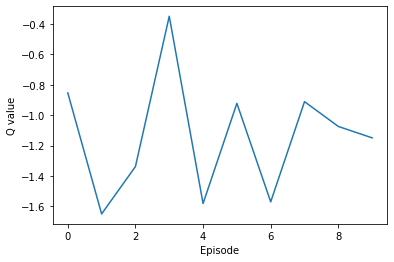

In [0]:
Episode = 10
iterations = 100
monitored_state = None
monitored_Q=[]
print("Overall Progress...")
total_progress = widgets.IntProgress(min=0, max=iterations*Episode*2)
display(total_progress)
for j in range(Episode):
  message = "Episode {} Progress...".format(j)
  label = widgets.Label(value=message)
  episode_progress = widgets.IntProgress(min=0, max=iterations*2)
  the_episode = widgets.HBox([label, episode_progress])
  display(the_episode)
  for i in range(iterations):
      topology.ap[0].GetPackets()

      for node in topology.i_nodes:
          node.GiveInterference()
    
      for client in topology.ap[0].clients:
          client.GetPackets()
    
      state = agent.GetState()
      print("State: {}".format(state))

      if(j==0 and i==0):
        monitored_state = state

      agent.SelectAction(Istrained=False,greedy=0.5)

      for node in topology.i_nodes:
          node.GiveInterference()

      agent.Learn((j+1)*(i+1))

      total_progress.value+=1
      episode_progress.value+=1

  reward = 0
  for i in range(iterations):
      topology.ap[0].GetPackets()

      for node in topology.i_nodes:
          node.GiveInterference()
    
      for client in topology.ap[0].clients:
          client.GetPackets()
    
      state = agent.GetState()
      print("State: {}".format(state))

      agent.SelectAction(Istrained=True,greedy=1.0)

      for node in topology.i_nodes:
          node.GiveInterference()

      reward += agent.GetReward((j+1)*(i+1))

      total_progress.value+=1
      episode_progress.value+=1
  the_episode.close()
  monitored_Q.append(agent.DeepQ.predict(np.asarray([monitored_state]))[0][0])

plt.plot(monitored_Q)
plt.xlabel('Episode')
plt.ylabel('Q value')


  







Selected Action: (-1, -1, -1, -1)
Executed Action: [-1 -1 -1  0]
Received reward: -0.2 from client 0 by successful download [1, 1, 1, 1, 1]
Received reward: -0.2 from client 1 by successful download [0, 1, 0, 1, 1]
Received reward: -0.2 from client 2 by successful download [1, 1, 1, 1, 1]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1 -1  0 -1]
Received reward: -0.4 from client 0 by successful download [1, 1, 1, 1, 1]
Received reward: -0.2 from client 1 by successful download [1, 0, 1, 1, 1]
Received reward: 0.4 from client 3 by successful download but failed latent threshold [0, 0, 1, 0, 1]
Selected Action: (-1, -1, -1, -1)
Executed Action: [-1  0 -1 -1]
Received reward: -0.2 from client 0 by successful download [1, 1, 1, 1, 1]
Received reward: -0.2 from client 2 by successful download [1, 1, 1, 0, 1]
Received reward: -0.4 from client 3 by successful download [0, 1, 0, 1, 1]
Selected Action: (-1, -1, -1, -1)
Executed Action: [ 0 -1 -1 -1]
Received reward: -0.4 from client 1 by

Text(0, 0.5, 'Average Reward')

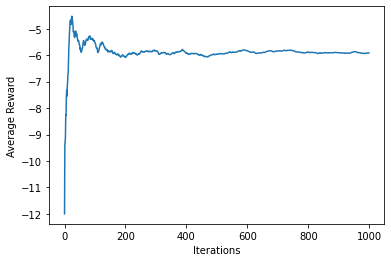

In [0]:
iterations = 1000
average_datastreams = []
reward = 0
for i in range(iterations):
      topology.ap[0].GetPackets()

      for node in topology.i_nodes:
          node.GiveInterference()
    
      for client in topology.ap[0].clients:
          client.GetPackets()
    
      state = agent.GetState()

      agent.SelectAction(Istrained=True,greedy=1.0)

      for node in topology.i_nodes:
          node.GiveInterference()

      reward += agent.GetReward(i+1)
      average_datastreams.append(reward/(i+1))

plt.plot(average_datastreams)
plt.xlabel('Iterations')
plt.ylabel('Average Reward')

Simulation Progress...


IntProgress(value=0, max=200)

Executed Action: [1 2 0 0]
Received reward: 0.2 from client 0 by successful upload but failed latent threshold [1, 0, 0, 0, 1]
Received reward: 1.0 from client 1 by successful upload but failed latent threshold [0, 1, 0, 0, 1]
Received reward: 0.8 from client 1 by successful download but failed latent threshold [1, 0, 0, 0, 1]
Executed Action: [0 0 0 0]
Executed Action: [ 1 -1 -1  0]
Received reward: 0.2 from client 0 by successful upload but failed latent threshold [0, 0, 1, 0, 1]
Received reward: 0.4 from client 1 by successful download but failed latent threshold [0, 0, 1, 0, 1]
Received reward: 0.6 from client 2 by successful download but failed latent threshold [1, 0, 0, 0, 1]
Executed Action: [1 0 0 1]
Received reward: -0.4 from client 0 by successful upload [0, 1, 0, 1, 1]
Received reward: 0.6 from client 3 by successful upload but failed latent threshold [0, 0, 0, 0, 1]
Executed Action: [0 2 0 0]
Received reward: 1.0 from client 1 by successful upload but failed latent threshol

Text(0, 0.5, 'Average Reward')

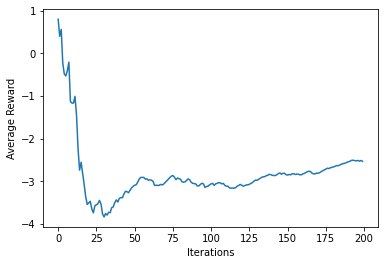

In [0]:
iterations = 200
print("Simulation Progress...")
total_progress = widgets.IntProgress(min=0, max=iterations)
display(total_progress)
average_datastreams = []
reward = 0
for i in range(iterations):
    topology.ap[0].GetPackets()

    for node in topology.i_nodes:
        node.GiveInterference()
    
    for client in topology.ap[0].clients:
        client.GetPackets()
    
    state = agent.GetState()

    #random select an action
    agent.last_action=agent.current_action
    index = randint.rvs(0,len(agent.action_space))
    agent.current_action=np.asarray(agent.action_space[index])
    agent.ExecuteAction()

    for node in topology.i_nodes:
        node.GiveInterference()

    reward+=agent.GetReward(i+1)

    average_datastreams.append(reward/(i+1))

    total_progress.value+=1

plt.plot(average_datastreams)
plt.xlabel('Iterations')
plt.ylabel('Average Reward')